**Name:** Veljko Kovac

**EID:** 55173123

In [1]:
# %matplotlib inline
import IPython.core.display         
# setup output image format (Chrome works best)
IPython.core.display.set_matplotlib_formats("svg")
import matplotlib.pyplot as plt
import matplotlib
from numpy import *
from sklearn import *
import glob
import os
import csv
import string
random.seed(100)

## 1. Loading Data and Pre-processing


In [2]:
filename = 'OnlineNewsPopularity/OnlineNewsPopularity.csv'

# read the data
allfeatnames = []
textdata      = []
with open(filename, 'r') as f:
    reader = csv.reader(f)
    for row in reader:
        if len(allfeatnames)==0:
            allfeatnames = row
        else:
            textdata.append(row)

# put the data into a np array
dataX = empty((len(textdata), len(allfeatnames)-3))
dataY = empty(len(textdata))
for i,row in enumerate(textdata):
    # extract features (remove the first 2 features and the last feature)
    dataX[i,:] = array([float(x) for x in row[2:-1]])
    # extract target (last entry)
    dataY[i] = float(row[-1])
    
# extract feature names
featnames = [x.strip() for x in allfeatnames[2:-1]]

# extract a subset of data
dataX = dataX[::6]
dataY = dataY[::6]

print(dataX.shape)
print(dataY.shape)

(6608, 58)
(6608,)


There are 58 features for each article.  Here are the feature names, and an example entry.  The actual description of the features can be found in the `OnlineNewsPopularity-features.txt` file.

In [3]:
print(featnames)

print("--- example article features---")
print(dataX[0])
print("--- example article target (# of shares)")
print(dataY[0])

['n_tokens_title', 'n_tokens_content', 'n_unique_tokens', 'n_non_stop_words', 'n_non_stop_unique_tokens', 'num_hrefs', 'num_self_hrefs', 'num_imgs', 'num_videos', 'average_token_length', 'num_keywords', 'data_channel_is_lifestyle', 'data_channel_is_entertainment', 'data_channel_is_bus', 'data_channel_is_socmed', 'data_channel_is_tech', 'data_channel_is_world', 'kw_min_min', 'kw_max_min', 'kw_avg_min', 'kw_min_max', 'kw_max_max', 'kw_avg_max', 'kw_min_avg', 'kw_max_avg', 'kw_avg_avg', 'self_reference_min_shares', 'self_reference_max_shares', 'self_reference_avg_sharess', 'weekday_is_monday', 'weekday_is_tuesday', 'weekday_is_wednesday', 'weekday_is_thursday', 'weekday_is_friday', 'weekday_is_saturday', 'weekday_is_sunday', 'is_weekend', 'LDA_00', 'LDA_01', 'LDA_02', 'LDA_03', 'LDA_04', 'global_subjectivity', 'global_sentiment_polarity', 'global_rate_positive_words', 'global_rate_negative_words', 'rate_positive_words', 'rate_negative_words', 'avg_positive_polarity', 'min_positive_polarit

Now separate the data into training and testing sets.

In [4]:
# randomly split data into 50% train and 50% test set
trainX, testX, trainYo, testYo = \
  model_selection.train_test_split(dataX, dataY, 
  train_size=0.50, test_size=0.50, random_state=4487)

print(trainX.shape)
print(testX.shape)

(3304, 58)
(3304, 58)


Finally, we normalize the input features.

In [5]:
# normalize feature values
# this makes comparing weights more meaningful
scaler = preprocessing.StandardScaler()  
trainXn = scaler.fit_transform(trainX)  
testXn  = scaler.transform(testX)    

Because the target value (number of shares) has a large dynamic range, we will transform the target values through the log function.

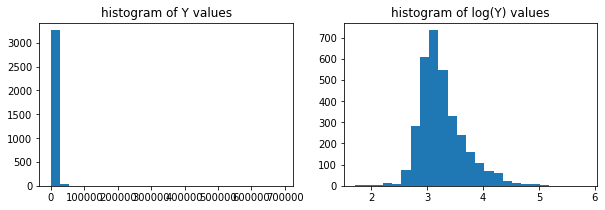

In [6]:
# map targets to log-space
trainY = log10(trainYo)
testY  = log10(testYo)

plt.figure(figsize=(10,3))
plt.subplot(1,2,1)
plt.hist(trainYo, 25);
plt.title('histogram of Y values')
plt.subplot(1,2,2)
plt.hist(trainY, 25);
plt.title("histogram of log(Y) values");

## 2. Prediction with Linear Regression

First we will look at predicting the number of shares using simple linear regression models. 

In [7]:
linreg = linear_model.LinearRegression()
ridge = linear_model.Ridge(alpha=1.0)


linreg_fit = linreg.fit(trainXn, trainY)
ridge_fit = ridge.fit(trainXn, trainY)


predY_linreg = linreg.predict(testXn)
predY_ridge = ridge.predict(testXn)


linreg_acc = metrics.mean_absolute_error(predY_linreg, testY)
ridge_acc = metrics.mean_squared_error(predY_ridge, testY)


print("The error of linear regression is: "+ str(linreg_acc))
print("The error of ridge regression is: "+ str(ridge_acc))



The error of linear regression is: 187.48206441843962
The error of ridge regression is: 0.14607019477006344


In [8]:
alphas = logspace(-3,6,50)
ridgecv = linear_model.RidgeCV(alphas=alphas, cv=5)
ridgecv.fit(trainXn, trainY)
ridgecv_acc = metrics.mean_squared_error(testY, ridgecv.predict(testXn))

print("The error of ridgeCV is: "+ str(ridgecv_acc))


The error of ridgeCV is: 0.14582813195944766


Compare the two models

In [9]:
# ols is the linear regression model

trainAE = metrics.mean_absolute_error(trainY, linreg.predict(trainXn))
testAE  = metrics.mean_absolute_error(testY, linreg.predict(testXn))

print("Linear Regression: train error =", trainAE)
print("Linear Regression: test error =", testAE)

Linear Regression: train error = 0.28690827091489324
Linear Regression: test error = 187.48206441843962


In [10]:
trainAE = metrics.mean_absolute_error(trainY, ridgecv.predict(trainXn))
testAE  = metrics.mean_absolute_error(testY, ridgecv.predict(testXn))
print("RidgeCV: train error =", trainAE)
print("RidgeCV: test error =", testAE)

RidgeCV: train error = 0.2889851504763784
RidgeCV: test error = 0.28565855588912115


## 3. Importance of Features
Next we will investigate which features are the most important for the prediction. 

In [11]:
# LASSO
las = linear_model.LassoCV()
las_fit = las.fit(trainXn, trainY)
train_acc = metrics.mean_absolute_error(trainY, las.predict(trainXn))
test_acc = metrics.mean_absolute_error(testY, las.predict(testXn))
print("train error =",trainAE)
print("test error =",testAE)

train error = 0.2889851504763784
test error = 0.28565855588912115


C:\Users\DELL\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


Examine the LASSO coefficients by sorting them in descending order.

In [12]:
# sort coefficients from smallest to largest, then reverse it
inds = argsort(abs(las.coef_))[::-1]
# print out
print("weight : feature description")
for i in inds:
    print("{: .3f} : {}".format(las.coef_[i], featnames[i]))

weight : feature description
 0.094 : kw_avg_avg
-0.042 : LDA_02
-0.038 : kw_max_avg
-0.034 : data_channel_is_entertainment
-0.027 : average_token_length
 0.025 : global_subjectivity
 0.025 : num_hrefs
 0.022 : kw_min_min
-0.022 : data_channel_is_bus
 0.022 : is_weekend
 0.020 : LDA_00
 0.019 : n_tokens_content
 0.018 : data_channel_is_socmed
-0.018 : kw_avg_min
 0.015 : self_reference_avg_sharess
-0.013 : max_positive_polarity
 0.012 : title_sentiment_polarity
-0.012 : data_channel_is_lifestyle
 0.009 : weekday_is_sunday
-0.008 : LDA_01
-0.007 : avg_negative_polarity
-0.007 : kw_avg_max
 0.007 : n_tokens_title
 0.006 : self_reference_max_shares
 0.006 : num_keywords
-0.006 : kw_min_max
-0.005 : weekday_is_friday
 0.005 : weekday_is_monday
 0.004 : data_channel_is_tech
-0.004 : weekday_is_tuesday
-0.003 : num_self_hrefs
 0.003 : LDA_03
-0.002 : min_positive_polarity
-0.002 : rate_positive_words
 0.002 : num_imgs
 0.002 : self_reference_min_shares
-0.002 : max_negative_polarity
 0.001 :